In [ ]:

import pandas as pd
import numpy as np

FILE_PATH = 'healthcare(Unknow).csv'
TARGET = 'stroke'


NUM_COLS = ['age', 'avg_glucose_level', 'bmi']
CAT_COLS = ['hypertension', 'heart_disease', 'gender', 'Residence_type',
            'work_type', 'smoking_status']  # có thể bớt/đổi theo nhu cầu

USE_COLS = NUM_COLS + CAT_COLS + [TARGET]

df = pd.read_csv(FILE_PATH)
df.columns = [c.strip() for c in df.columns]
data = df[USE_COLS].copy()

# Ép numeric cho cột số
for c in NUM_COLS + [TARGET, 'hypertension', 'heart_disease']:
    data[c] = pd.to_numeric(data[c], errors='coerce')

# Label-encode cho các cột phân loại dạng text (gender, Residence_type, work_type, smoking_status...)
from sklearn.preprocessing import LabelEncoder
encoders = {}
for c in CAT_COLS:
    if data[c].dtype == 'object':
        le = LabelEncoder()
        data[c] = data[c].astype(str).str.strip()
        data[c] = le.fit_transform(data[c])
        encoders[c] = le  # lưu lại encoder nếu cần inverse_transform

# Bỏ NA
data = data.dropna()

X = data[NUM_COLS + CAT_COLS].values
y = data[TARGET].astype(int).values

# Chỉ định vị trí categorical cho SMOTE-NC (index theo X)
categorical_idx = [i for i, c in enumerate(NUM_COLS + CAT_COLS) if c in CAT_COLS]

# SMOTE-NC
from imblearn.over_sampling import SMOTENC
sm = SMOTENC(categorical_features=categorical_idx, random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)

# Tạo DataFrame cân bằng
balanced_cols = NUM_COLS + CAT_COLS
balanced_df = pd.DataFrame(X_bal, columns=balanced_cols)
balanced_df[TARGET] = y_bal

# (Tuỳ chọn) Nếu muốn đưa lại dạng text cho các cột đã encode:
for c in CAT_COLS:
    if c in encoders:
        balanced_df[c] = encoders[c].inverse_transform(balanced_df[c].astype(int))

# LƯU CSV GIỮ NHIỀU CỘT
balanced_df.to_csv('balanced_stroke_smote_nc.csv', index=False)
print('Đã lưu: balanced_stroke_smote_nc.csv')
print('Phân phối trước:', dict(pd.Series(y).value_counts().sort_index()))
print('Phân phối sau  :', dict(pd.Series(y_bal).value_counts().sort_index()))


Đã lưu: balanced_stroke_smote_nc.csv
Phân phối trước: {0: np.int64(4860), 1: np.int64(249)}
Phân phối sau  : {0: np.int64(4860), 1: np.int64(4860)}


Đã lưu 4 hình PNG.


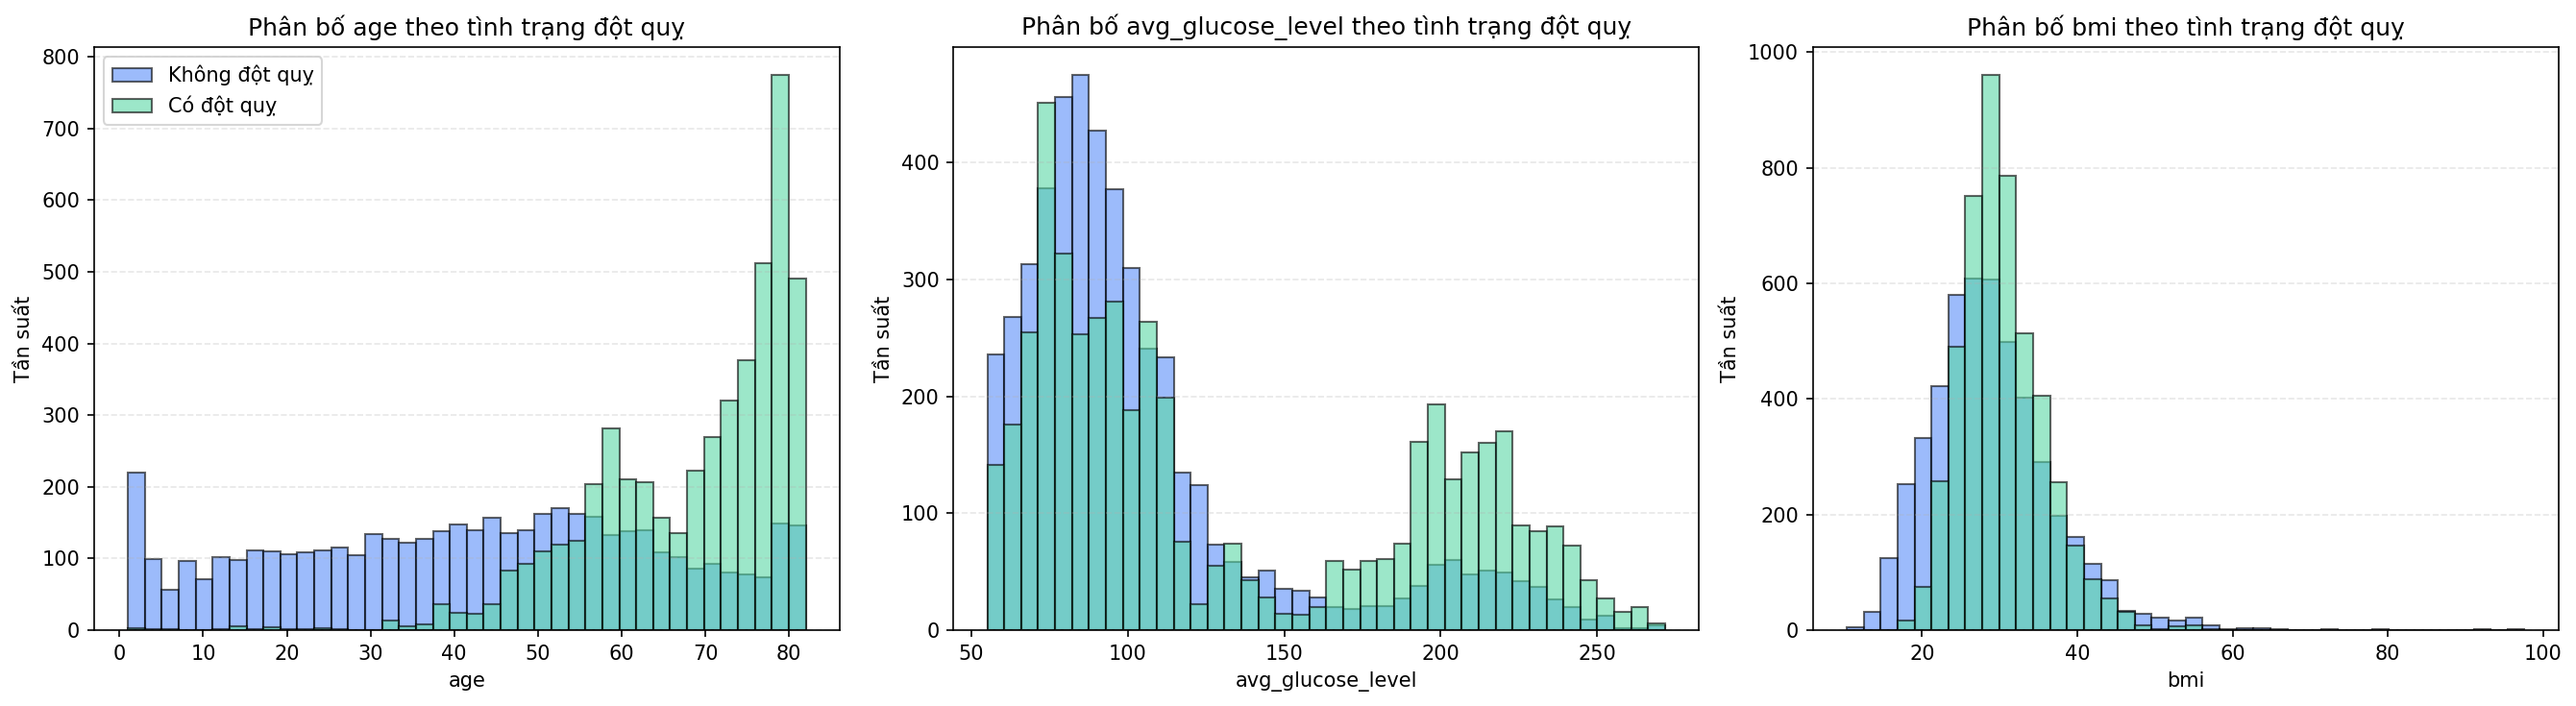

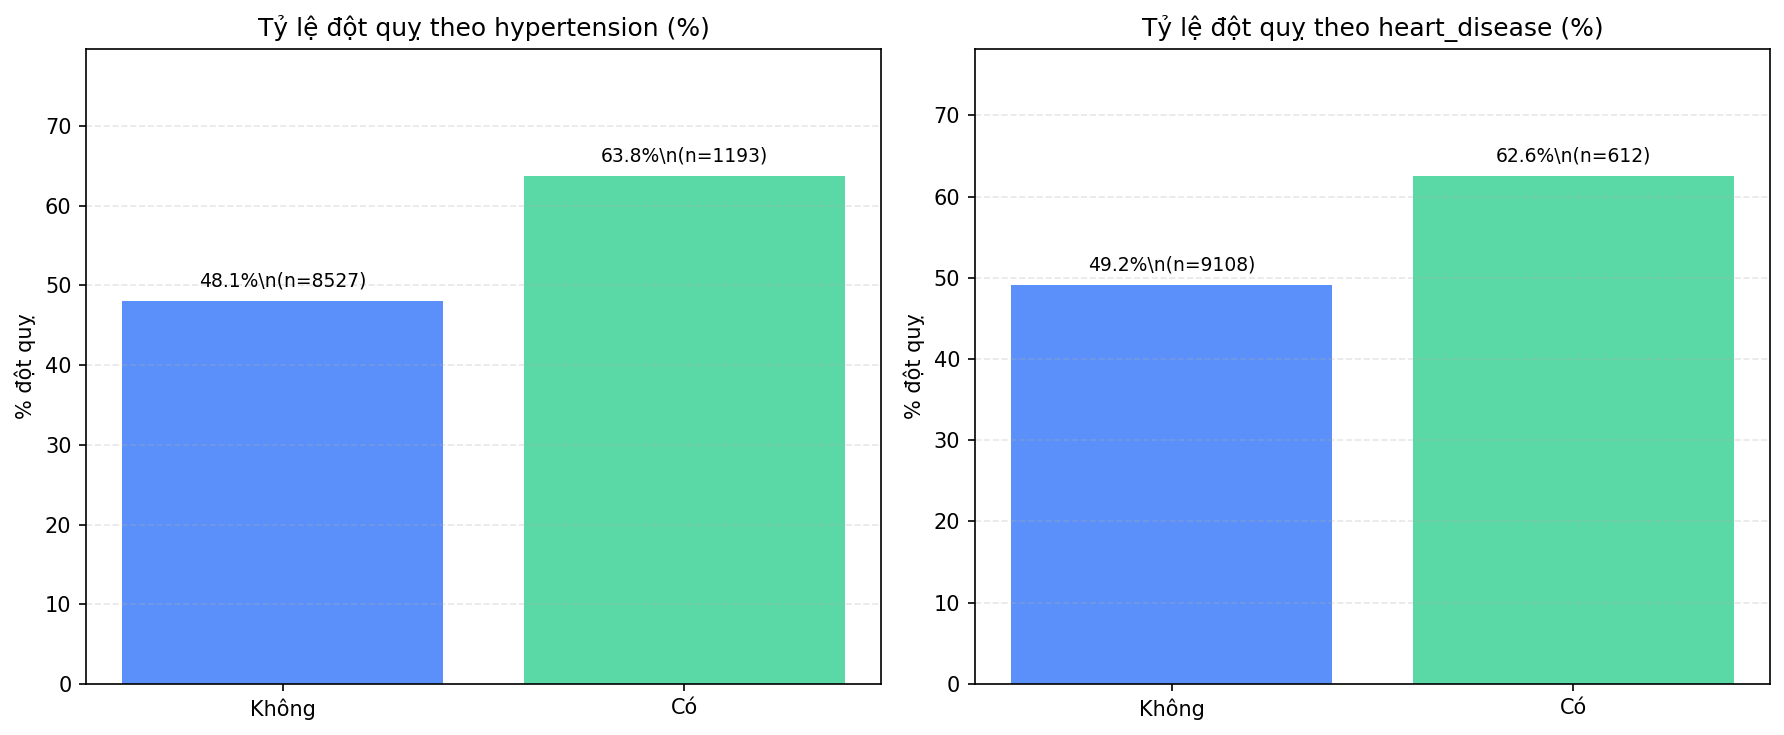

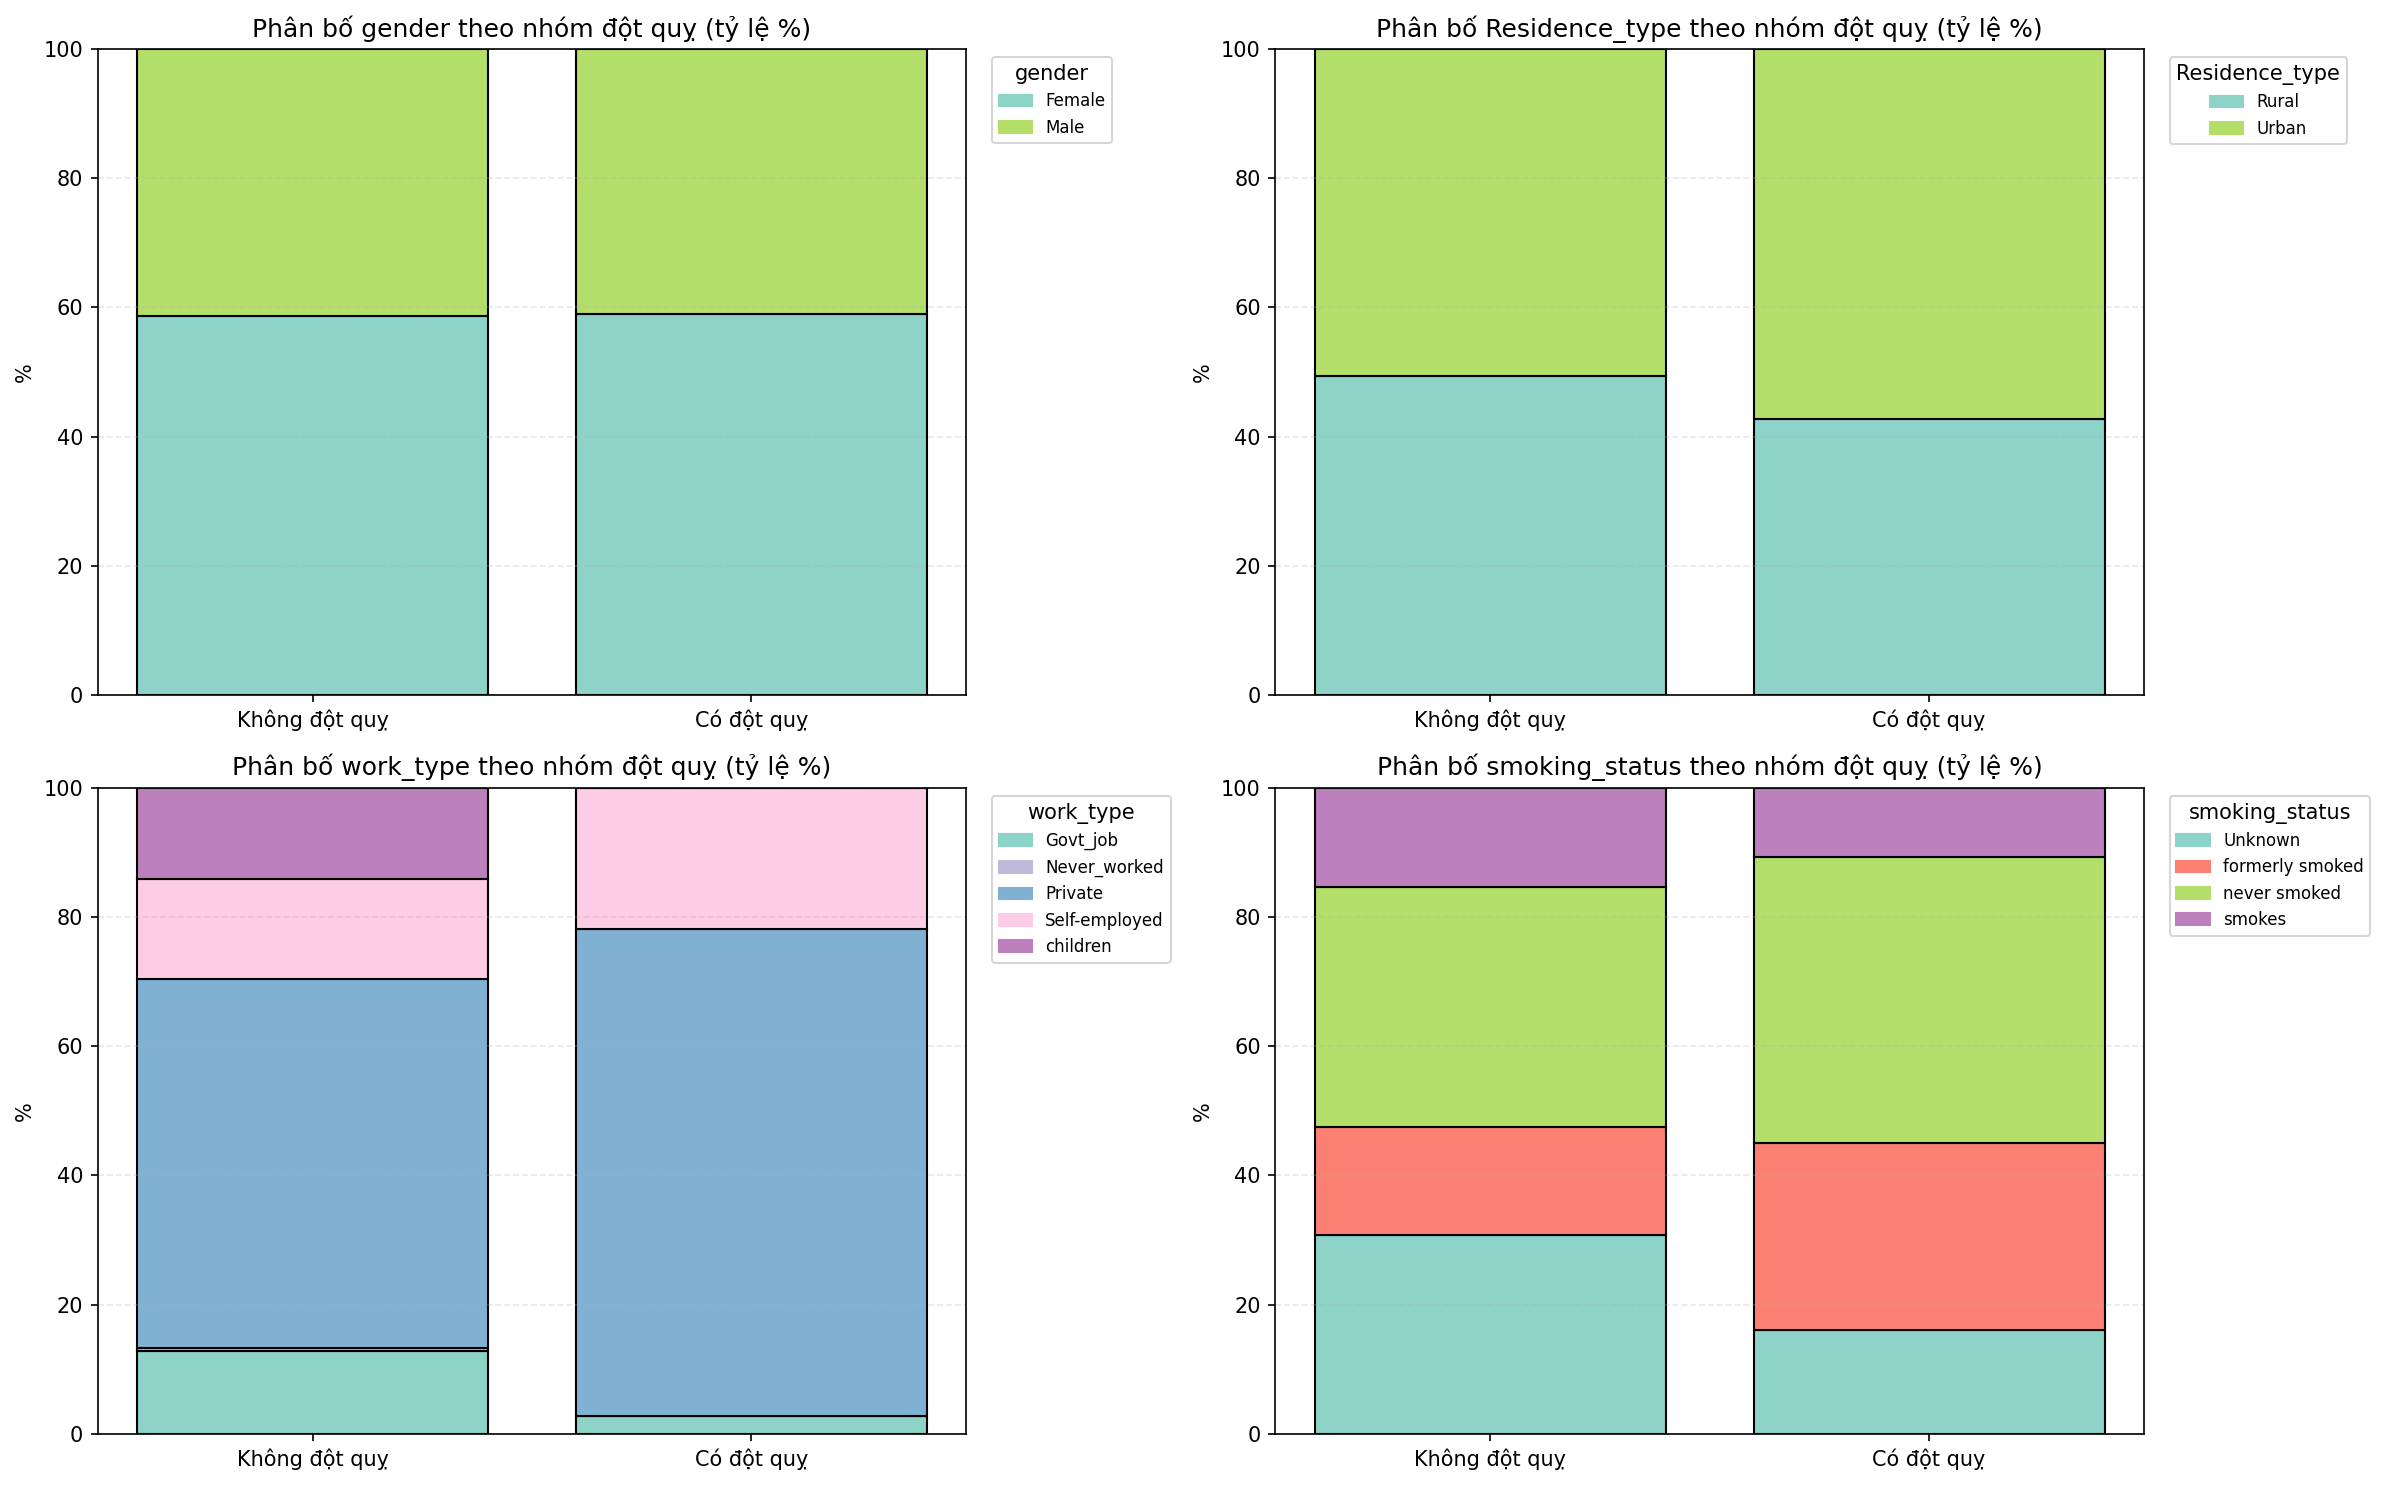

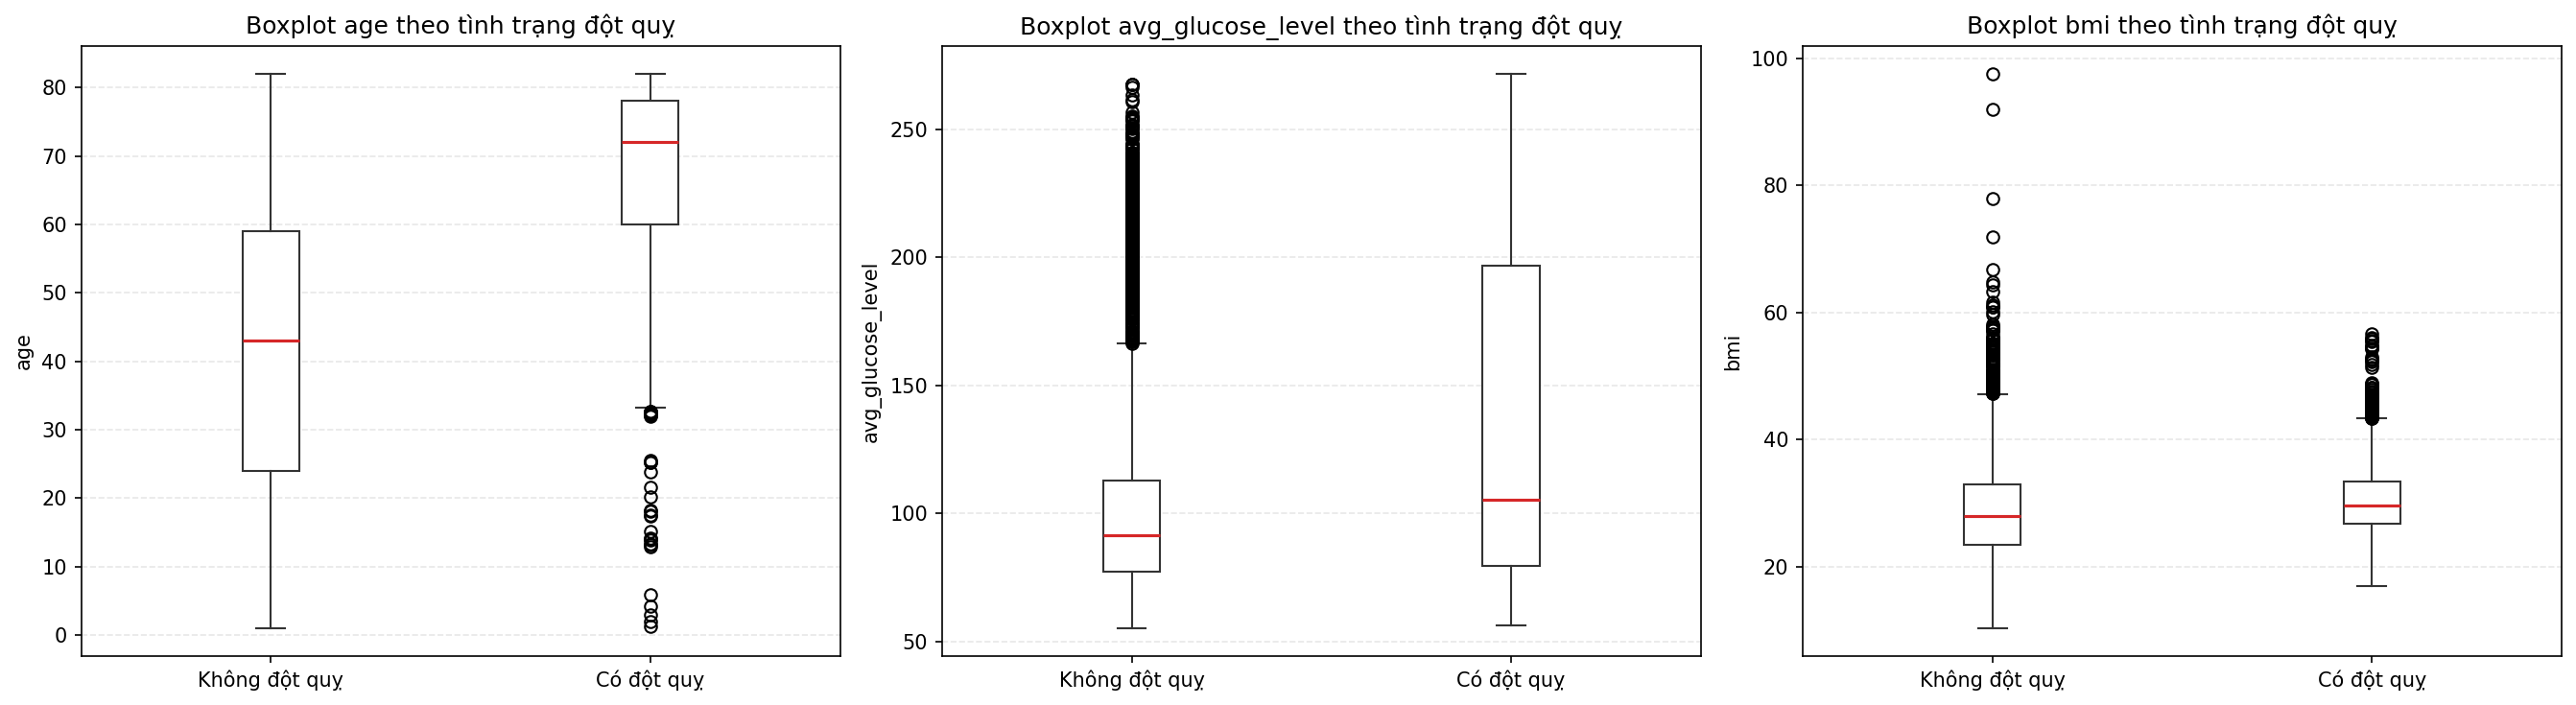

In [35]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = 'balanced_stroke_smote_nc.csv'
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

num_cols = ['age', 'avg_glucose_level', 'bmi']
bin_cols = ['hypertension', 'heart_disease']
cat_cols = ['gender', 'Residence_type', 'work_type', 'smoking_status']
# 1) Histogram các biến số liên tục
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 5), dpi=150)
colors = ['#5B8FF9', '#5AD8A6']
for i, col in enumerate(num_cols):
    sub = df.dropna(subset=[col])
    v0 = sub.loc[sub['stroke']==0, col].values
    v1 = sub.loc[sub['stroke']==1, col].values
    bins = np.histogram_bin_edges(np.concatenate([v0, v1]), bins=40)
    axes1[i].hist(v0, bins=bins, alpha=0.6, color=colors[0], label='Không đột quỵ', edgecolor='black')
    axes1[i].hist(v1, bins=bins, alpha=0.6, color=colors[1], label='Có đột quỵ', edgecolor='black')
    axes1[i].set_title(f'Phân bố {col} theo tình trạng đột quỵ')
    axes1[i].set_xlabel(col); axes1[i].set_ylabel('Tần suất')
    axes1[i].grid(axis='y', linestyle='--', alpha=0.3)
axes1[0].legend()
plt.tight_layout(); plt.savefig('stroke_fig_numeric_hist.png', bbox_inches='tight')

# 2) % đột quỵ theo hypertension & heart_disease
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
for i, col in enumerate(bin_cols):
    sub = df.dropna(subset=[col]); sub[col] = sub[col].astype(int)
    rate = (sub.groupby(col)['stroke'].mean() * 100).sort_index()
    count = sub.groupby(col)['stroke'].count().sort_index()
    xs = [0,1]
    axes2[i].bar(xs, rate.values, color=colors)
    axes2[i].set_xticks(xs); axes2[i].set_xticklabels(['Không','Có'])
    axes2[i].set_title(f'Tỷ lệ đột quỵ theo {col} (%)'); axes2[i].set_ylabel('% đột quỵ')
    axes2[i].set_ylim(0, max(rate.values)*1.25); axes2[i].grid(axis='y', linestyle='--', alpha=0.3)
    for j, v in enumerate(rate.values):
        axes2[i].text(xs[j], v + max(rate.values)*0.02, f'{v:.1f}%\\n(n={count.iloc[j]})',
                      ha='center', va='bottom', fontsize=9)
plt.tight_layout(); plt.savefig('stroke_fig_binary_rates.png', bbox_inches='tight')

# 3) Stacked % cho các biến phân loại
fig3, axes3 = plt.subplots(2, 2, figsize=(16, 10), dpi=150)
axes3 = axes3.ravel()
for i, col in enumerate(cat_cols):
    sub = df.dropna(subset=[col]); sub[col] = sub[col].astype(str).str.strip()
    tab = sub.groupby(['stroke', col]).size().unstack(fill_value=0)
    pct = (tab.T / tab.sum(axis=1)).T * 100
    x = np.array([0,1]); b0 = 0; b1 = 0; cats = list(pct.columns)
    for j, cat in enumerate(cats):
        c = plt.cm.Set3(j / max(1, len(cats)))
        axes3[i].bar(0, pct.loc[0, cat] if 0 in pct.index else 0, bottom=b0, color=c, edgecolor='black')
        axes3[i].bar(1, pct.loc[1, cat] if 1 in pct.index else 0, bottom=b1, color=c, edgecolor='black')
        b0 += pct.loc[0, cat] if 0 in pct.index else 0
        b1 += pct.loc[1, cat] if 1 in pct.index else 0
    axes3[i].set_xticks([0,1]); axes3[i].set_xticklabels(['Không đột quỵ','Có đột quỵ'])
    axes3[i].set_title(f'Phân bố {col} theo nhóm đột quỵ (tỷ lệ %)'); axes3[i].set_ylabel('%'); axes3[i].set_ylim(0,100)
    axes3[i].grid(axis='y', linestyle='--', alpha=0.3)
    handles = [plt.Rectangle((0,0),1,1,color=plt.cm.Set3(j / max(1, len(cats)))) for j in range(len(cats))]
    axes3[i].legend(handles, cats, title=col, bbox_to_anchor=(1.02,1), loc='upper left', fontsize=8)
plt.tight_layout(); plt.savefig('stroke_fig_categorical_stacked.png', bbox_inches='tight')

# 4) Boxplot các biến số liên tục
fig4, axes4 = plt.subplots(1, 3, figsize=(18, 5), dpi=150)
for i, col in enumerate(num_cols):
    sub = df.dropna(subset=[col])
    data0 = sub.loc[sub['stroke']==0, col].values
    data1 = sub.loc[sub['stroke']==1, col].values
    axes4[i].boxplot([data0, data1], positions=[0,1], patch_artist=True,
                     boxprops=dict(facecolor='#FFFFFF', edgecolor='#333'),
                     medianprops=dict(color='#D62728', linewidth=1.5),
                     whiskerprops=dict(color='#333'), capprops=dict(color='#333'))
    axes4[i].set_xticks([0,1]); axes4[i].set_xticklabels(['Không đột quỵ','Có đột quỵ'])
    axes4[i].set_title(f'Boxplot {col} theo tình trạng đột quỵ'); axes4[i].set_ylabel(col)
    axes4[i].grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout(); plt.savefig('stroke_fig_numeric_box.png', bbox_inches='tight')
print('Đã lưu 4 hình PNG.')

for c in num_cols + bin_cols + ['stroke']:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=['stroke'])
